<a href="https://colab.research.google.com/github/Nishasathish13/TheSchoolofAI-END3.0/blob/main/Session%2011_12%20-%20BERT%20and%20BART/Assignment/TASK1_Session_11_12_BERT_and_BART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

####https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

If we have a very large set of such texts together with sample questions and the position of the answers in the text, we can train a neural network to learn relationships between context, questions, and answers. The resulting network would be able to answer unseen questions given new contexts which are similar to the training texts.

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Downloading the required files and dataset

In [2]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

--2022-02-04 05:21:58--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12493 (12K) [text/plain]
Saving to: ‘utils_squad_evaluate.py’

utils_squad_evaluat 100%[===================>]  12.20K  --.-KB/s    in 0s      

2022-02-04 05:21:58 (53.9 MB/s) - ‘utils_squad_evaluate.py’ saved [12493/12493]

--2022-02-04 05:21:58--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awai

In [2]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

## Importing the required libraries

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## Mounting the drive

In [5]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [6]:
!ls

sample_data  train-v2.0.json  utils_squad_evaluate.py  utils_squad.py


In [7]:
import sys
sys.path.append('/content/')

In [8]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
input_file = '/content/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [11]:
examples = examples[:10000]

In [12]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

#doc_tokens describes the context, i.e. the text which we want our model to understand.
#question_text describes the question which should be answered from the context.
#orig_answer_text represents the correct answer to the question.
#The answer is always a portion from the context starting at start_position and ending at end_position. 
#If the question does not have any answer in the context, is_impossible has the value true.

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [13]:
len(train_data)

10000

In [14]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
1026,56cbfbdd6d243a140015ee36,Who did Frédéric meet in the spring of 1834 at...,"[In, the, spring, of, 1834,, Chopin, attended,...",Felix Mendelssohn,23,24,False
1027,56cbfbdd6d243a140015ee37,What two activities did Frédéric do while visi...,"[In, the, spring, of, 1834,, Chopin, attended,...",playing and discussing music,49,52,False
1028,56cbfbdd6d243a140015ee38,Who was the director of the Academy of Art tha...,"[In, the, spring, of, 1834,, Chopin, attended,...",Friedrich Wilhelm Schadow,58,60,False
1029,56cbfbdd6d243a140015ee39,Where were Frédéric's parents located at when ...,"[In, the, spring, of, 1834,, Chopin, attended,...",Carlsbad,85,85,False
1030,56cf7b8a4df3c31400b0d81f,Where did Chopin meet Felix Mendelssohn?,"[In, the, spring, of, 1834,, Chopin, attended,...",the Lower Rhenish Music Festival,7,11,False
1031,56cf7b8a4df3c31400b0d820,Who did Chopin attend the Lower Rhenish Music ...,"[In, the, spring, of, 1834,, Chopin, attended,...",Hiller,15,15,False
1032,56cf7b8a4df3c31400b0d821,In 1835 where did Chopin and his parents visit?,"[In, the, spring, of, 1834,, Chopin, attended,...",Carlsbad,85,85,False
1033,56cf7b8a4df3c31400b0d822,When did Chopin propose marriage to Maria Wodz...,"[In, the, spring, of, 1834,, Chopin, attended,...",July 1836,208,209,False
1034,56cf7b8a4df3c31400b0d823,Who was Maria's mother?,"[In, the, spring, of, 1834,, Chopin, attended,...",Countess Wodzińska,231,232,False
1035,56d31f8a59d6e41400146262,Who did Chopin meet at a music festival early ...,"[In, the, spring, of, 1834,, Chopin, attended,...",Felix Mendelssohn,23,24,False


In [15]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('lenght of train_data:',len(train_data))
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [16]:
print_squad_sample(train_data)

lenght of train_data: 10000
CONTEXT: 
The Legend of Zelda: Twilight Princess is an action-adventure game focused on combat, exploration,
and item collection. It uses the basic control scheme introduced in Ocarina of Time,
including context-sensitive action buttons and L-targeting (Z-targeting on the Wii), a system that allows
the player to keep Link's view focused on an enemy or important object while
moving and attacking. Link can walk, run, and attack, and will automatically jump when
running off of or reaching for a ledge.[c] Link uses a sword and shield
in combat, complemented with secondary weapons and items, including a bow and arrows, a
boomerang, bombs, and the Clawshot (similar to the Hookshot introduced earlier in the The
Legend of Zelda series).[d] While L-targeting, projectile-based weapons can be fired at a target
without the need for manual aiming.[c]
QUESTION:                                                                                            ANSWER:
What are the 

In [17]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
3883,56cf55aeaab44d1400b89033,Approximately how many tech sector jobs are in...,"[Silicon, Alley,, centered, in, Manhattan,, ha...","300,000",181,181,False,187,61
1740,56ce5125aab44d1400b886b0,When did the Qianlong Emperor reign?,"[When, the, Dzungar, Mongols, attempted, to, s...",1735–1796,47,47,False,76,37
5754,56d2a28059d6e41400146172,Buddhist concept of dependent origination has ...,"[Buddhism, provides, many, opportunities, for,...",scientific,88,88,False,95,83
7361,56d9779ddc89441400fdb4d1,What actor attended a torch celebration in China?,"[China:, The, torch, returned, to, China, for,...",Jackie Chan,35,36,False,59,49
4114,56d00b23234ae51400d9c2c5,The bridge made with steel-wire is which in NYC?,"[The, George, Washington, Bridge, is, the, wor...",The Brooklyn Bridge,35,37,False,99,48


In [18]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 97.94%


In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 319503.19B/s]


In [20]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [21]:
cached_features_file = '/content/cache_train'

In [22]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [23]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [24]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [25]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [26]:
import glob
checkpoints = sorted(glob.glob('/content/checkpoint*-[0-9]*'))

In [27]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [28]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/content/checkpoint*-[0-9]*'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:35<00:00, 12347404.82B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [29]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0012,  0.0158, -0.0244,  ..., -0.0016, -0.0123, -0.0077],
        [ 0.0288,  0.0194, -0.0117,  ..., -0.0030,  0.0195,  0.0072]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [30]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [31]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set),os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 11192
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 699


Iteration:   0%|          | 0/699 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Epoch: 100%|██████████| 1/1 [17:53<00:00, 1073.93s/it]


In [34]:
output_dir = '/content/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))

In [35]:
train_loss_set_ckpt = torch.load('/content/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

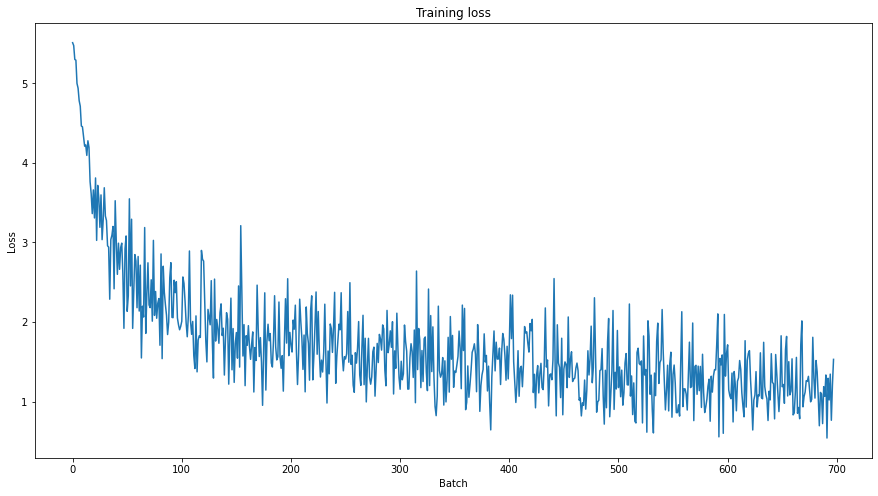

In [36]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [37]:
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'

--2022-02-04 06:35:22--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       100%[===================>]   4.17M  6.90MB/s    in 0.6s    

2022-02-04 06:35:23 (6.90 MB/s) - ‘dev-v2.0.json’ saved [4370528/4370528]



In [38]:
input_file = '/content/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [39]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [40]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [41]:
def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content//dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/predictions.json"
  output_nbest_file = "/content/nbest_predictions.json"
  output_null_log_odds_file = "/content/null_odds.json"
  output_dir = "/content/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [42]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating: 100%|██████████| 850/850 [07:38<00:00,  1.86it/s]


{
  "exact": 47.435357533900444,
  "f1": 50.487904952582106,
  "total": 11873,
  "HasAns_exact": 48.852901484480434,
  "HasAns_f1": 54.96675025337497,
  "HasAns_total": 5928,
  "NoAns_exact": 46.021867115222875,
  "NoAns_f1": 46.021867115222875,
  "NoAns_total": 5945,
  "best_exact": 50.720121283584604,
  "best_exact_thresh": -10.577834963798523,
  "best_f1": 51.372878131502176,
  "best_f1_thresh": -1.611396312713623
}


In [43]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 47.435357533900444}, {'f1': 50.487904952582106}, {'total': 11873}, {'HasAns_exact': 48.852901484480434}, {'HasAns_f1': 54.96675025337497}, {'HasAns_total': 5928}, {'NoAns_exact': 46.021867115222875}, {'NoAns_f1': 46.021867115222875}, {'NoAns_total': 5945}, {'best_exact': 50.720121283584604}, {'best_exact_thresh': -10.577834963798523}, {'best_f1': 51.372878131502176}, {'best_f1_thresh': -1.611396312713623}]


**Evaluate on any text**